<table class="ee-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/walkerlab/FENS-2022/blob/main/notebooks/Filled_Deep-Learning-in-Neuroscience.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run in Google Colab</a>
</td><td>
<a target="_blank"  href="https://github.com/walkerlab/FENS-2022/blob/main/notebooks/Filled_Deep-Learning-in-Neuroscience.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a></td></table>

# Digging deeper into the training

In the [main notebook](./Deep-Learning-in-Neuroscience.ipynb), we made exclusive use of `train_model` function to take care of a lot of details of the training. In this notebook, we are going to develop our own, albeit simpler training routine to get a better appreciation of what goes into training neural networks.

## Part 0: Preparing the environment

Again, we are going to prepare the environment by downloading the necessary library (e.g. `FENS-2022`) and the dataset. This is necessary as each colab notebook ends up offering distinct environment by default.

In [2]:
# Clone and install the FENS package
!git clone https://github.com/walkerlab/FENS-2022.git
!pip3 install -e FENS-2022

Cloning into 'FENS-2022'...
remote: Enumerating objects: 350, done.
remote: Counting objects: 100% (350/350), done.
remote: Compressing objects: 100% (196/196), done.
remote: Total 350 (delta 173), reused 322 (delta 148), pack-reused 0
Receiving objects: 100% (350/350), 1.57 MiB | 9.27 MiB/s, done.
Resolving deltas: 100% (173/173), done.
Obtaining file:///content/FENS-2022
  Attempting uninstall: fens
    Found existing installation: fens 0.1
    Uninstalling fens-0.1:
      Successfully uninstalled fens-0.1
  Running setup.py develop for fens


In [3]:
# download the dataset
!wget -nc "https://onedrive.live.com/download?cid=06D44059794C5B46&resid=6D44059794C5B46%21121992&authkey=AHJVfxtvAASasjQ" -O dataset.zip

# Unzip
!unzip -nq 'dataset.zip'

# get trained network weights
!git clone https://gin.g-node.org/walkerlab/fens-2022.git /content/trained_nets

File ‘dataset.zip’ already there; not retrieving.
fatal: destination path '/content/trained_nets' already exists and is not an empty directory.


Finally we go ahead and implment a bunch of standard libraries.

In [4]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
import seaborn as sns

### Loading data files one at a time

Let's pick some trial and load the image as well as the response

In [6]:
trial_idx = 1100
trial_image = np.load(f'./Lurz2020/static20457-5-9-preproc0/data/images/{trial_idx}.npy')
trial_responses = np.load(f'./Lurz2020/static20457-5-9-preproc0/data/responses/{trial_idx}.npy')

The image is shaped as $\text{channel} \times \text{height} \times \text{width}$

In [7]:
trial_image.shape

(1, 36, 64)

### TRY IT OUT
Inspect the loaded image and the corresponding neuronal responses (e.g. visualize the image stimulus). How many neurons are there?

(-0.5, 63.5, 35.5, -0.5)

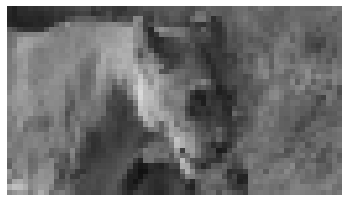

In [8]:
plt.imshow(trial_image.squeeze(), cmap='gray', vmin=0, vmax=255)
plt.axis('off')

The shape of `trial_response` is simply the number of neurons

In [9]:
trial_responses.shape

(5335,)

In [10]:
trial_responses.min() # responses are practically always >= 0

-5.409307320414307e-10

In [11]:
trial_responses.max()

53.39189366955226

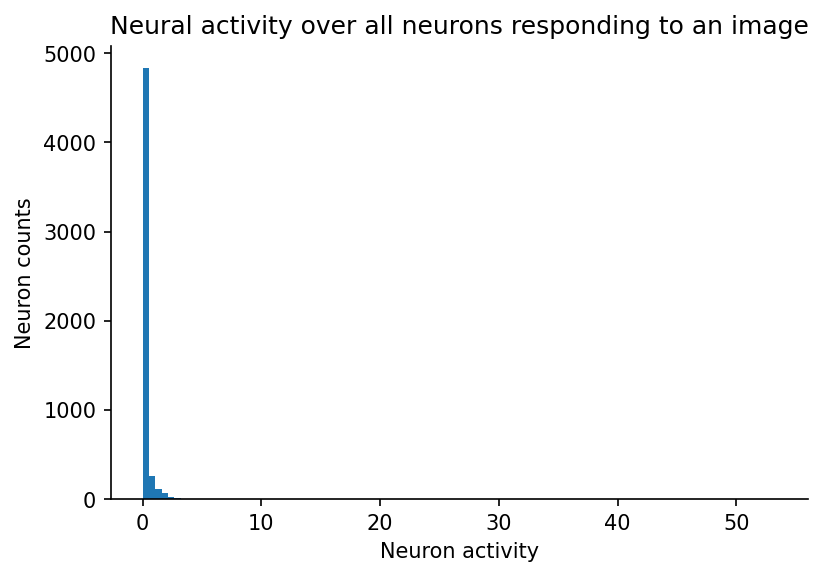

In [12]:
fig, ax = plt.subplots(1, 1, dpi=150)
ax.hist(trial_responses, 100);
ax.set_title('Neural activity over all neurons responding to an image')
ax.set_xlabel('Neuron activity')
ax.set_ylabel('Neuron counts')
sns.despine()

You can see most neuron's responses stay very close to 0 - signifying no activity.

### Loading the entire dataset

While we can inspect the image and the corresponding neural population responses one image at a time, this is quite cumbersome and also impractical for use in network training. Fortunately, the `fens` package provides us with a convenience function that will help to load the entire dataset as PyTorch [dataloaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader).

In [13]:
from fens.dataset import load_dataset

As we prepare the dataloaders, we get to specify the **batch size**.

In [14]:
dataloaders = load_dataset(path = './Lurz2020/static20457-5-9-preproc0', batch_size=60)

The function returns a dictionary consisting of three dataloaders for training, validation, and test set.

In [15]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7fb669b5cc70>,
 'validation': <torch.utils.data.dataloader.DataLoader at 0x7fb669b5cb20>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7fb669b5c9d0>}

Let's specifically look at the trainset dataloader

In [16]:
train_loader = dataloaders['train']

Total number of images can be checked as follows:

In [17]:
len(train_loader.sampler)

4472

We can inspect what it returns per batch:

In [18]:
images, responses = next(iter(train_loader))

In [19]:
images.shape

torch.Size([60, 1, 36, 64])

In [20]:
responses.shape

torch.Size([60, 5335])

As expected, you can see it returns a batch size of 60 images and responses for all neurons.

Similar inspection can be done on the **validation** and **testing** dataloaders.

In [21]:
# number of images in validation set
len(dataloaders['validation'].sampler)

522

In [22]:
# number of images in test set
len(dataloaders['test'].sampler)

999

You might think that we have a lot of images in test set, but this is because test set consists of repeated images.

Some additional trial information can be observed by accessing the underlying PyTorch dataset object and looking at the `trial_info`. Note that this is not part of the standard PyTorch dataset/dataloader interface, but rather a feature specifically provided by our `fens` library!

In [23]:
# Access to the dataset object that underlies all dataloaders
dataset = dataloaders['test'].dataset

In [24]:
# get trials that are marked as "test" set
test_trials = np.where(dataset.trial_info.tiers == 'test')[0]

In [25]:
# get information about the presented image for ALL trials
image_ids = dataset.trial_info.frame_image_id

In [26]:
# find IDs of all unique images presented during test trials
unique_test_images = np.unique(image_ids[test_trials])
unique_test_images

array([ 104,  128,  183,  355,  479,  483,  656,  803,  830,  936, 1201,
       1494, 1596, 1652, 1656, 1682, 1731, 1756, 1796, 2005, 2008, 2014,
       2159, 2214, 2389, 2586, 2710, 2746, 2747, 2803, 2816, 2825, 2954,
       3018, 3107, 3144, 3163, 3372, 3427, 3438, 3487, 3507, 3562, 3702,
       3847, 3924, 4231, 4295, 4373, 4397, 4400, 4430, 4594, 4619, 4667,
       4674, 4717, 4739, 4782, 4812, 4814, 4821, 4923, 4953, 5034, 5128,
       5166, 5225, 5264, 5288, 5322, 5334, 5399, 5402, 5504, 5640, 5671,
       5679, 5754, 5782, 6013, 6034, 6066, 6082, 6205, 6238, 6248, 6490,
       6562, 6773, 6790, 6831, 6886, 7017, 7028, 7107, 7119, 7120, 7154,
       7495])

In [27]:
len(unique_test_images)

100

We can see that the test set consists of 100 unique images, each repeated up to 10 times.

Let's now take a look at how a neuron responds to these repeated presentations of an identical image.

In [28]:
from tqdm import tqdm
# gather the responses to the repeated image presentations
repeated_image_responses = []
for unique_test_image_id in tqdm(unique_test_images):
    repeated_image_trials = test_trials[image_ids[test_trials] == unique_test_image_id]
    responses = np.stack([dataset[trial][1].cpu().numpy() for trial in repeated_image_trials])
    repeated_image_responses.append((unique_test_image_id, responses))

100%|██████████| 100/100 [00:01<00:00, 97.46it/s]


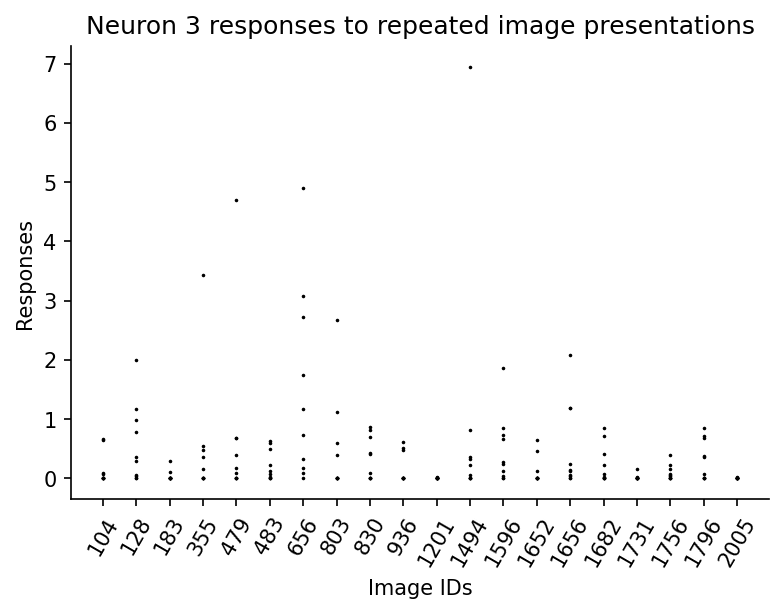

In [29]:
neuron_idx = 3 # choose one neuron to inspect its responses

fig, ax = plt.subplots(1, 1, dpi=150)
labels = []
for i, (image_id, responses) in enumerate(repeated_image_responses[:20]):
    ax.scatter(np.ones(len(responses)) * i, responses[:, neuron_idx], c='k', s=0.5)
    labels.append(image_id)

ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=60)
ax.set_title(f'Neuron {neuron_idx} responses to repeated image presentations')
ax.set_xlabel('Image IDs')
ax.set_ylabel('Responses')
sns.despine()

### TRY IT OUT
Take a look at the responses of other neurons. Can you also plot the "mean" response for each image? How about their standard deviation?

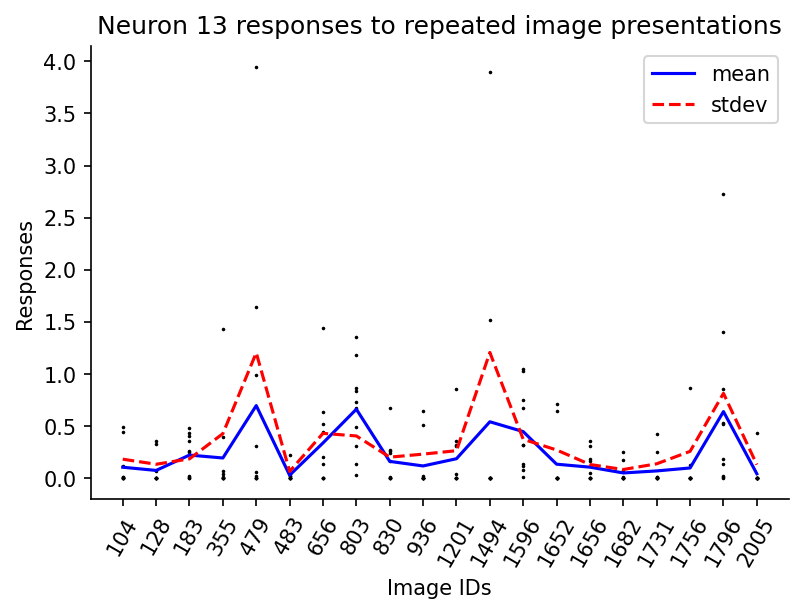

In [30]:
neuron_idx = 13 # choose one neuron to inspect its responses

fig, ax = plt.subplots(1, 1, dpi=150)
labels = []
mean_responses = []
std_responses = []
for i, (image_id, responses) in enumerate(repeated_image_responses[:20]):
    unit_responses = responses[:, neuron_idx]
    ax.scatter(np.ones(len(unit_responses)) * i, unit_responses, c='k', s=0.5)
    mean_responses.append(unit_responses.mean())
    std_responses.append(unit_responses.std())
    labels.append(image_id)

# plot the mean curve
ax.plot(mean_responses, 'b-', label='mean')
ax.plot(std_responses, 'r--', label='stdev')

ax.legend()
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=60)
ax.set_title(f'Neuron {neuron_idx} responses to repeated image presentations')
ax.set_xlabel('Image IDs')
ax.set_ylabel('Responses')
sns.despine()

You can see that indeed a single neuron's responses vary widely even to repeated presentations of an identical stimulus!

This so-called **noiseness** of neural responses make predicting the respones of the neurons to images fundamentally challenging and in fact makes it  essentially impossible to yield a perfect fit!

Instead, we would often try to fit the **distribution of responses** the best we can, and we will briefly visit this point later.

# Modeling the neuronal responses

Now that we have successfully loaded the dataset and inspected its contents, it's time for us to start **modeling** the responses.

We will start by building a very basic **Linear-Nonlinear model** - which is nothing more than a shallow neural network with single linear layer followed by an activation function.

## Linear-Nonlinear (LN) model

### Background

Arguably one of the simplest models of a neuron's response to a stimulus is the **linear-nonlinear (LN) model**. 

Given an image $I \in \mathbb{R}^{h\,\times\,w}$ where $h$ and $w$ are the height and the width of the image, respectively, let us collapse the image into a vector $x \in \mathbb{R}^{hw}$.

A single neuron's response $r$ under linear-nonlinear model can then be expressed as:
$$
r = a(\mathbf{w}^\top x + b),
$$
where $\mathbf{w} \in \mathbb{R}^{hw}$ and $b \in \mathbb{R}$ are **weight** and **bias**, and $a:\mathbb{R}\mapsto\mathbb{R}$ is a scalar **activating function**.

We can in fact extend to capture the responses of all $N$ neurons simultaneously as:

$$
\mathbf{r} = a(\mathbf{W} x + \mathbf{b}),
$$
where $\mathbf{r} \in \mathbb{R}^{N}$, $\mathbf{W} \in \mathbb{R}^{N\,\times\,hw}$ and $\mathbf{b} \in \mathbb{R}^{N}$.

Hence, each neuron weighs each pixel of the image according to the weight $\mathbf{w}$ (corresopnds to a row of $\mathbf{W}$) and thus characterizes how much the each neuron "cares" about a specific pixel.

The weight $\mathbf{w}$ can be thought of as a **filter** that's the same size as the image and is overlaid on top of the image to determine what pixel would contribute to the neuron's response. 

This *image filter* is typically referred to as the **receptive field** of the neuron!

The nonlinear activation function $a(\cdot)$ ensures, among other things, that the output of the network stays above 0. In fitting neuronal responses, we tend to use $a(x) = ELU(x) + 1$ where ELU (Exponential Linear Unit) is defined as follows:

$$
    ELU(x) = 
\begin{cases}
    e^x - 1, & x \lt 0 \\
    x,   & x \ge 0
\end{cases}
$$

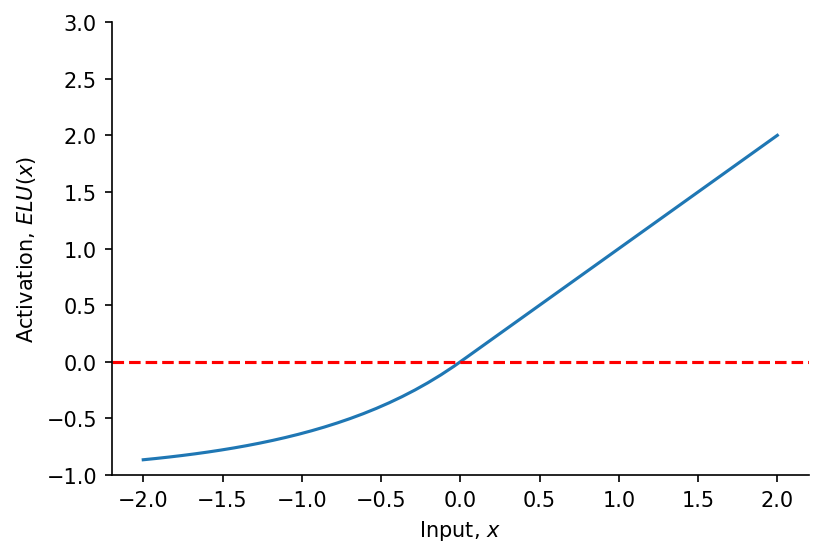

In [31]:
# Plotting ELU function
fig, ax = plt.subplots(1, 1, dpi=150)
x = np.linspace(-2, 2)
ax.plot(x, F.elu(torch.Tensor(x)))
ax.axhline(0, c='r', ls='--')
ax.set_xlabel(r'Input, $x$')
ax.set_ylabel(r'Activation, $ELU(x)$')
ax.set_ylim([-1, 3])
sns.despine()

We shift it by 1 to ensure it will always remain positive.

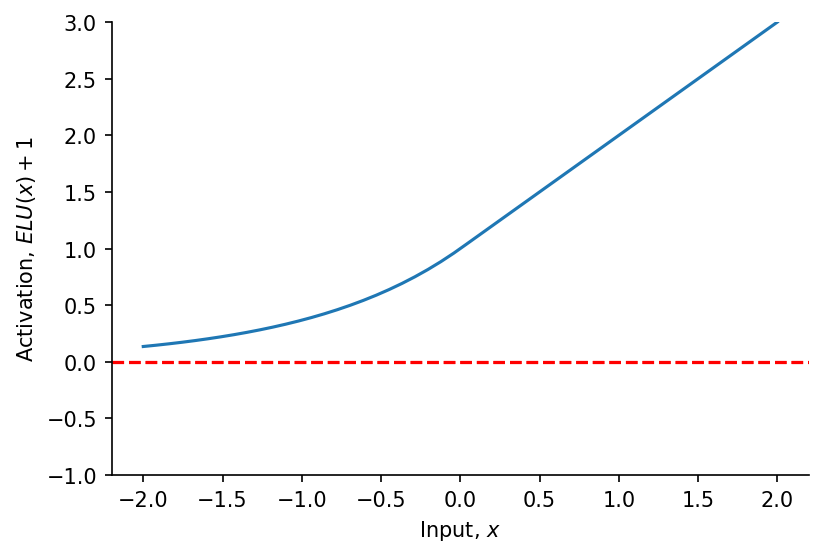

In [32]:
# Plotting ELU+1 function
fig, ax = plt.subplots(1, 1, dpi=150)
x = np.linspace(-2, 2)
ax.plot(x, F.elu(torch.Tensor(x))+1)
ax.axhline(0, c='r', ls='--')
ax.axhline(0, c='r', ls='--')
ax.set_xlabel(r'Input, $x$')
ax.set_ylabel(r'Activation, $ELU(x) + 1$')
ax.set_ylim([-1, 3.0])
sns.despine()

Overall, it can be seen that a linear-nonlinear (LN) model is nothing more than a single linear layer applied on a flattened image input, followed by a nonlinear activation function (i.e. $ELU(x)+1$). 

Now let's go ahead and implment our LN model in PyTorch!

### Implementation

We implement a simple network consisting of a linear layer followed by ELU + 1 activation

### TRY IT OUT
Implement a simple Linear-Nonlinear network using PyTorch.

In [33]:
class Linear(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        momentum=0.1,
        init_std=1e-3,
        gamma=0.0,
    ):
        super().__init__()
        self.bn = nn.BatchNorm2d(1, momentum=momentum, affine=False)
        self.linear = nn.Linear(input_height * input_width, n_neurons)
        self.gamma = gamma
        self.init_std = init_std
        self.initialize()
        
    
    def forward(self, x):
        x = self.bn(x)
        x = self.linear(x.flatten(1))
        return nn.functional.elu(x) + 1
        

    def initialize(self, std=None):
        if std is None:
            std = self.init_std
        nn.init.normal_(self.linear.weight.data, std=std)


    def regularizer(self):
        return self.gamma * self.linear.weight.abs().sum()


And that's it! We have now designed our first model of the neuron's responses!

**BONUS**: notice that we used batch normalization (BN) layer right before the linear layer? This empirically helps to stabilize the training, allowing us to be not too sensitive to the weight and bias initialization. You could implement and train a LN network without such BN layer and you are encouraged to try! However if you do, be wary of the network weight initializations and the choice of learning rate during the training.

### Training the network

Now that we have a candidate model designed, it's time to train it. What should be the objective (loss) function we optimize? It's fairly common in the system identification field to use **Poisson loss** and this actually reflects our belief about the neuron's distribution given the stimulus. Let's now take some time to delve into what motivates this choice of Poisson loss and what are its implications.

### Mathematical aside: Poisson Loss

#### How we are **actually** modeling the noisy neuronal responses

The use of **Poisson loss** follows from the assumption that, *conditioned on the stimulus*, the neurons' responses follow an **independent Poisson** distribution. That is, given an input image $x$, the population response $\mathbf{r}$ is distributed as:

$$
p(\mathbf{r} | x) = \prod_i^N \text{Poiss}(r_i; \lambda_i(x))
$$

where $r_i$ is the $i^\text{th}$ neuron in the population $\mathbf{r}$. The $\lambda_i$ is the parameter for Poisson distribution that controls its **average value**. Here we express $\lambda_i(x)$ to indicate the fact that the average response for each neuron is expected to vary *as a function of the input image*. We can express this average matching as:

$$
\mathbb{E}[r_i|x] = \lambda_i(x)
$$

In fact, it is precisely this function $\lambda_i(x)$ that we are modeling using LN models and, in the next step, more complex neural networks. In otherwords, we are learning $\lambda_i(x) = f_i(x, \theta)$, where $\theta$ is the trainable parameters of the model.

Putting all together, this means that, our model $f(x, \theta)$ is really modeling the average activity of the neurons,

$$
\mathbb{E}[\mathbf{r}|x] = \mathbf{f}(x, \theta)
$$

while we are assuming that the neurons are distributed according to **independent Poisson** distribution around the average responses predicted by our model $\mathbf{f}(x, \theta)$.

#### Deriving the objective function

Poisson distribution is defined as follows:

$$
p(r) = \text{Poiss}(r; \lambda) = \frac{e^{-\lambda}\lambda^{r}}{r!}
$$

During the training, we would want to adjust the model parameter $\theta$ to maximize the chance of observing the response $\mathbf{r}$ to a known image $x$. This is achieved by **maximizing** the log-likelihood function $\log p(\mathbf{r}|x, \theta)$, or equivalently by **minimzing the negative log-likelihood function** as the objective function $L(x, \mathbf{r}, \theta)$:

$$
\begin{align}
L(x, \mathbf{r}, \theta) &= -\log p(\mathbf{r}|x, \theta) \\
&= -\log \prod_i \text{Poiss}(r_i; f_i(x, \theta)) \\
&= -\sum_i \log \frac{e^{-f_i(x, \theta)}f_i(x, \theta)^{r_i}}{r_i!} \\
&= \sum_i \left(f_i(x, \theta) - r_i \log f_i(x, \theta) + \log r_i! \right)
\end{align}
$$


During the optimization, we seek for $\theta$ that would minimize the loss $L$. Note that since the term $\log r_i!$ does not depend on $\theta$, it can be safely dropped from Poisson loss. Hence you would commonly see the following expression as the definition of the **Poisson loss**

$$
L_\text{Poiss}(x, \mathbf{r}, \theta) = \sum_i \left(f_i(x, \theta) - r_i \log f_i(x, \theta)\right)
$$

### Performing the training - simple routine

Now that we have the theoretical foundation for the training and the choice of the objective function under our belt, let's go ahead and train the network. Let's go ahead and build our network and define our training routine, using a simple `SGD` (stochastic gradient descient optimizer).

First of all, let's instantiate the model to train.

In [65]:
ln_model = Linear(input_height=64, input_width=36, n_neurons=5335, gamma=0.1)

Now that we have instantiated a network to train, let's define a routine to train the network. We will train on our training dataset, and periodically report the performance on the validation dataset. As discussed above, we will make use of Poisson Loss, which is simply the negative log likelihood of Poisson probability. This is conveniently given as `PoissonNLLLoss` in PyTorch.

In [67]:
from torch.optim import SGD
from torch.nn import PoissonNLLLoss
from scipy import percentile

In [78]:
def corr(y1, y2, axis=-1, eps=1e-8, **kwargs):
    """
    Compute the correlation between two matrices along certain dimensions.

    Args:
        y1:      first matrix
        y2:      second matrix
        axis:    dimension along which the correlation is computed.
        eps:     offset to the standard deviation to make sure the correlation is well defined (default 1e-8)
        **kwargs passed to final mean of standardized y1 * y2

    Returns: correlation vector

    """
    y1 = (y1 - y1.mean(axis=axis, keepdims=True)) / (
        y1.std(axis=axis, keepdims=True, ddof=0) + eps
    )
    y2 = (y2 - y2.mean(axis=axis, keepdims=True)) / (
        y2.std(axis=axis, keepdims=True, ddof=0) + eps
    )
    return (y1 * y2).mean(axis=axis, **kwargs)

In [77]:
N_EPOCHS = 10
N_REPORT = 100 # how often to report the performance on the validation set
lr = 0.01
device = 'cpu'

# log_input=False says that we intend to pass in response value directly, rather than log of responses
criterion = PoissonNLLLoss(log_input=False, reduction='sum')

# move model and criterion into the target device
ln_model.to(device)
criterion.to(device)

# define and setup the optimizer
optimizer = SGD(ln_model.parameters(), lr=lr)

train_dataloader = dataloaders['train']
valid_dataloader = dataloaders['validation']

In [71]:
z = next(iter(train_dataloader))

In [ ]:
optimizer.zero_grad()
for batch_no, (images, targets) in tqdm(train_dataloader, 
    enumerate(dataloaders["train"]),
    desc="Epoch {}".format(epoch),
):
    # put model into training mode
    model.train()
    
    # zero out the gradient
    optimizer.zero_grad()
    
    # move data into the target device
    images, targets = images.to(device), targets.to(device)
    
    # get predicted responses
    responses = ln_model(images)
    
    # compute the loss, with regularizers
    loss = criterion(responses, targets) + ln_model.regularizer()
    
    # compute the gradient
    loss.backward()
    
    # apply the learning step
    optimizer.step()
    
    
    loss = full_objective(model, dataloaders["train"], *data)
    loss.backward()
    if (batch_no + 1) % optim_step_count == 0:
        optimizer.step()
        optimizer.zero_grad()

 While we could use a standard set of optimizers as provided by PyTorch to implement our training routine, here, we are provided with a convenience function `train_model` that would handle a lot of the training boilerplate.

Critically, by default, `train_model` sets up the training based on **Poisson loss** and also perform early stopping based on **correlation** of the predicted neuronal responses with the actual neuronal responses on the **validation set**. Let's now talk briefly about our objective (loss) function of choice in training neuron response models - the Poisson loss.

Because the function `train_model` handles a lot underneath the hood, training a model is just as easy as invoking the function by passing it the model to be trained and the dataloaders!

In [36]:
from fens.trainers import train_model

In [37]:
score, output, model_state = train_model(model=ln_model, dataloader=dataloaders, device='cuda')


correlation -0.0009356685
poisson_loss 9502274.0


Epoch 1: 100%|██████████| 75/75 [00:04<00:00, 16.80it/s]


[001|00/05] ---> 0.06917500495910645
correlation 0.069175005
poisson_loss 3224339.0


Epoch 2: 100%|██████████| 75/75 [00:00<00:00, 188.52it/s]


[002|00/05] ---> 0.07183843851089478
correlation 0.07183844
poisson_loss 2913218.0


Epoch 3: 100%|██████████| 75/75 [00:00<00:00, 190.62it/s]


[003|00/05] ---> 0.08091381937265396
correlation 0.08091382
poisson_loss 2671174.5


Epoch 4: 100%|██████████| 75/75 [00:00<00:00, 191.22it/s]


[004|00/05] ---> 0.0813705250620842
correlation 0.081370525
poisson_loss 2711642.5


Epoch 5: 100%|██████████| 75/75 [00:00<00:00, 192.35it/s]


[005|01/05] -/-> 0.08106474578380585
correlation 0.081064746
poisson_loss 2582182.5


Epoch 6: 100%|██████████| 75/75 [00:00<00:00, 189.81it/s]


[006|01/05] ---> 0.08417712152004242
correlation 0.08417712
poisson_loss 2581324.0


Epoch 7: 100%|██████████| 75/75 [00:00<00:00, 192.20it/s]


[007|00/05] ---> 0.08483122289180756
correlation 0.08483122
poisson_loss 2548588.2


Epoch 8: 100%|██████████| 75/75 [00:00<00:00, 192.27it/s]


[008|00/05] ---> 0.09051598608493805
correlation 0.090515986
poisson_loss 2504264.5


Epoch 9: 100%|██████████| 75/75 [00:00<00:00, 164.26it/s]

[009|01/05] -/-> 0.08497723937034607


correlation 0.08497724
poisson_loss 2604073.0


Epoch 10: 100%|██████████| 75/75 [00:00<00:00, 169.01it/s]


[010|02/05] -/-> 0.07626267522573471
correlation 0.076262675
poisson_loss 2646683.2


Epoch 11: 100%|██████████| 75/75 [00:00<00:00, 169.50it/s]


[011|03/05] -/-> 0.08631046116352081
correlation 0.08631046
poisson_loss 2568281.2


Epoch 12: 100%|██████████| 75/75 [00:00<00:00, 169.93it/s]

[012|04/05] -/-> 0.08337458223104477


correlation 0.08337458
poisson_loss 2689327.5


Epoch 13: 100%|██████████| 75/75 [00:00<00:00, 169.85it/s]


[013|05/05] -/-> 0.08540832996368408
Restoring best model after lr decay! 0.085408 ---> 0.090516
correlation 0.090515986
poisson_loss 2504264.5


Epoch 14: 100%|██████████| 75/75 [00:00<00:00, 170.36it/s]

Epoch    14: reducing learning rate of group 0 to 1.5000e-03.
[014|01/05] -/-> 0.08667585253715515


correlation 0.08667585
poisson_loss 2610923.0


Epoch 15: 100%|██████████| 75/75 [00:00<00:00, 162.71it/s]


[015|01/05] ---> 0.10737787187099457
correlation 0.10737787
poisson_loss 2223543.5


Epoch 16: 100%|██████████| 75/75 [00:00<00:00, 169.56it/s]

[016|00/05] ---> 0.11040998995304108


correlation 0.11040999
poisson_loss 2193189.5


Epoch 17: 100%|██████████| 75/75 [00:00<00:00, 134.11it/s]


[017|01/05] -/-> 0.10622016340494156
correlation 0.10622016
poisson_loss 2215098.8


Epoch 18: 100%|██████████| 75/75 [00:00<00:00, 167.68it/s]


[018|02/05] -/-> 0.10863111168146133
correlation 0.10863111
poisson_loss 2197401.5


Epoch 19: 100%|██████████| 75/75 [00:00<00:00, 174.41it/s]

[019|03/05] -/-> 0.10664356499910355


correlation 0.106643565
poisson_loss 2211121.5


Epoch 20: 100%|██████████| 75/75 [00:00<00:00, 171.45it/s]

[020|04/05] -/-> 0.10677091032266617


correlation 0.10677091
poisson_loss 2207231.2


Epoch 21: 100%|██████████| 75/75 [00:00<00:00, 165.41it/s]


[021|05/05] -/-> 0.10399115085601807
Restoring best model after lr decay! 0.103991 ---> 0.110410
correlation 0.11040999
poisson_loss 2193189.5


Epoch 22: 100%|██████████| 75/75 [00:00<00:00, 172.19it/s]


[022|00/05] ---> 0.11124294251203537
correlation 0.11124294
poisson_loss 2221721.5


Epoch 23: 100%|██████████| 75/75 [00:00<00:00, 165.02it/s]


[023|01/05] -/-> 0.10840001702308655
correlation 0.10840002
poisson_loss 2215260.0


Epoch 24: 100%|██████████| 75/75 [00:00<00:00, 158.52it/s]


[024|02/05] -/-> 0.1076224073767662
correlation 0.10762241
poisson_loss 2210953.0


Epoch 25: 100%|██████████| 75/75 [00:00<00:00, 167.79it/s]


[025|03/05] -/-> 0.10672807693481445
correlation 0.10672808
poisson_loss 2229184.5


Epoch 26: 100%|██████████| 75/75 [00:00<00:00, 169.39it/s]


[026|04/05] -/-> 0.10577407479286194
correlation 0.105774075
poisson_loss 2219337.8


Epoch 27: 100%|██████████| 75/75 [00:00<00:00, 165.49it/s]


[027|05/05] -/-> 0.10379625856876373
Restoring best model after lr decay! 0.103796 ---> 0.111243
Restoring best model! 0.111243 ---> 0.111243


### Analyzing the trained network

Woohoo! We have now successfully trained our very first LN model on real neuronal responses! But really, how good is the model?

During the training, the `train_model` function iteratively reported two values: the loss function (Poisson loss) value and the average correlation. 

But what is this correlation? It's simply the correlation computed between our predicted neuronal responses $\hat{r}_i$ and the actual neuronal responses $r_i$ across images in the validation set. We then take the average correlation value **across neurons** to get average correlation.

Being a correlation, the highest possible value is of course 1.0. Practically speaking, this is never reached both due to 1) imperfection of our model and more fundamentally due to 2) the noiseness of the neuron's responses. Because of the noise, even a perfect model would never reach a correlation of 1.0.

Let's actually go ahead and look at the model's predicted responses on the **test set** and compare them against the actual responses.

The package `fens` provides for a convenient function to quickly gather the model's responses and the actual responses.

In [38]:
from fens.utility import measures
from scipy.stats import pearsonr

# here we evaluate the performance of the model on the test set
actual_responses, model_responses = measures.model_predictions(ln_model, dataloaders['test'], device='cuda')


### TRY IT OUT
Plot the predicted vs the actual responses to see how good our model performed. Also, compute and display Pearson correlation coefficient.

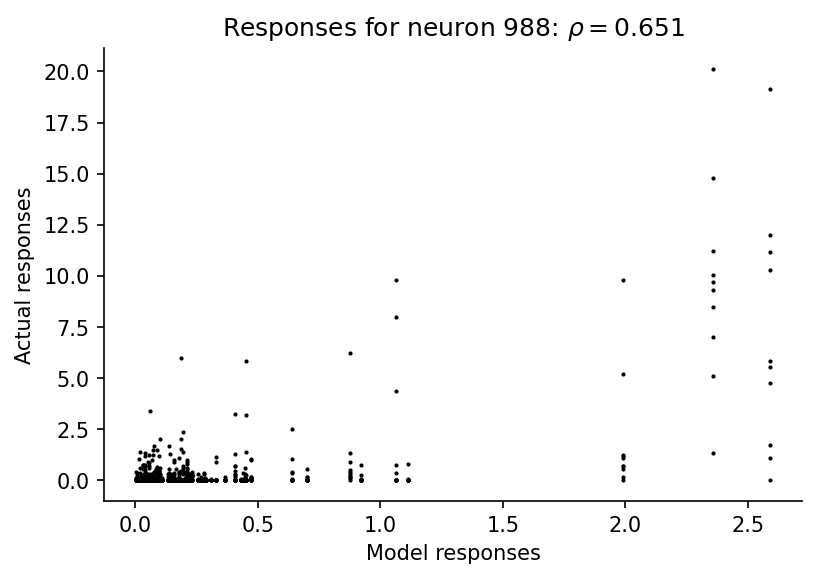

In [39]:
# pick a neuron to generate the plot for
neuron_idx = 988

# compute Pearson correlation
r, _ = pearsonr(model_responses[:, neuron_idx], actual_responses[:, neuron_idx])
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(model_responses[:, neuron_idx], actual_responses[:, neuron_idx], c='k', s=1.0)
ax.set_title(f'Responses for neuron {neuron_idx}: $\\rho = {r:.3f}$')
ax.set_xlabel('Model responses')
ax.set_ylabel('Actual responses')
sns.despine()

Let's take a look at how this correlation is distributed across neurons. This time, we'll use `get_gorrelations` function to compute correation for all neurons quickly.

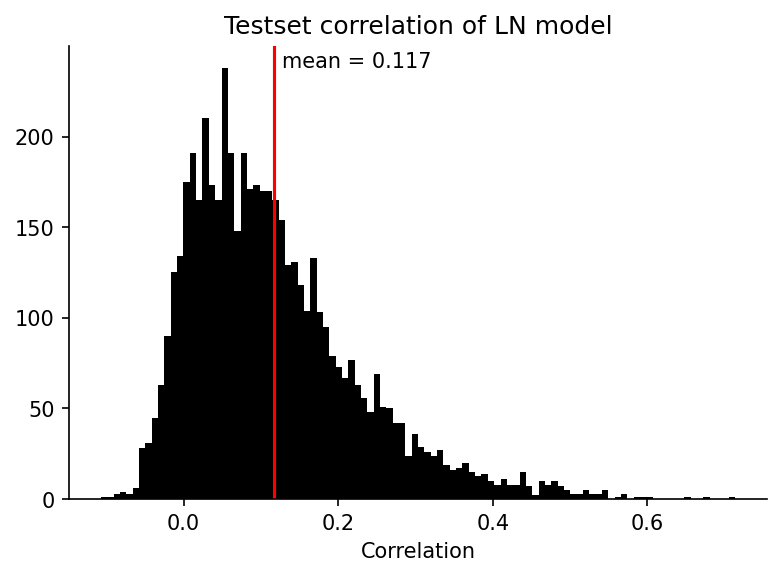

In [40]:
# compute correlation on test set
ln_test_correlations = measures.get_correlations(
    ln_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(ln_test_correlations, bins=100, color='k')
mean_corr = np.mean(ln_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of LN model')
ax.set_xlabel('Correlation')
sns.despine()

You can see that value of achieved correlation on the test set widely varies among the neurons. Some neurons are quite well predicted, reaching correlation above 0.6, where as many neurons have correlation well below 0.1.

## Going beyond Linear-Nonlinear model by using CNN

We saw that a simple LN model can be trained to achieve above chance performance in predicting the responses of mouse V1 neurons to natural images. But we certainly must be able to do better than that, right?

In the past decade, what has really driven system identification of visual neurons has been the use of convolutional neural networks (CNN). Below, we will try out a very simple CNN to see if we can already reach better performance than LN.

### TRY IT OUT
Implement a "simple" CNN to predict responses of neurons from images.

In [41]:
from collections import OrderedDict
class CNN(nn.Module):
    def __init__(
        self,
        input_height,
        input_width,
        n_neurons,
        momentum=0.1,
        init_std=1e-3,
        gamma=0.1,
        hidden_channels=8,
    ):
        super().__init__()
        self.init_std = init_std
        self.gamma = gamma

        # CNN core
        self.cnn_core = nn.Sequential(
            OrderedDict(
                [
                    ("conv1", nn.Conv2d(1, hidden_channels, 15, padding=15 // 2, bias=False)),
                    ("bn1", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu1", nn.ELU()),
                    ("conv2", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn2", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu2", nn.ELU()),
                    ("conv3", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn3", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu3", nn.ELU()),
                    ("conv4", nn.Conv2d(hidden_channels, hidden_channels, 13, padding=13 // 2, bias=False)),
                    ("bn4", nn.BatchNorm2d(hidden_channels, momentum=momentum)),
                    ("elu4", nn.ELU()),
                ]
            )
        )

        # Fully connected readout
        self.readout = nn.Sequential(
            OrderedDict(
                [
                    ('fc_ro', nn.Linear(input_height * input_width * hidden_channels, n_neurons)),
                    ('bn_ro', nn.BatchNorm1d(n_neurons, momentum=momentum)),
                ]
            )
        )


    def initialize(self, std=None):
        if std is None:
            std = self.init_std
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, std=std)

    def forward(self, x):
        x = self.cnn_core(x)
        x = x.view(x.size(0), -1)
        x = self.readout(x)
        return nn.functional.elu(x) + 1
    
    def regularizer(self):
        return self.readout[0].weight.abs().sum() * self.gamma


Let us now instantiate the model and train it!

In [42]:
cnn_model = CNN(input_height=64, input_width=36, n_neurons=5335)

In [43]:
score, output, model_state = train_model(model=cnn_model, dataloader=dataloaders, device='cuda')

correlation -0.00029753163
poisson_loss 4076447.0


Epoch 1: 100%|██████████| 75/75 [00:03<00:00, 19.40it/s]


[001|00/05] ---> 0.04387473687529564
correlation 0.043874737
poisson_loss 2516102.5


Epoch 2: 100%|██████████| 75/75 [00:03<00:00, 19.50it/s]


[002|00/05] ---> 0.11852602660655975
correlation 0.11852603
poisson_loss 2100190.5


Epoch 3: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[003|00/05] ---> 0.15071497857570648
correlation 0.15071498
poisson_loss 1915847.6


Epoch 4: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[004|01/05] -/-> 0.15014056861400604
correlation 0.15014057
poisson_loss 1911709.2


Epoch 5: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[005|01/05] ---> 0.1889030635356903
correlation 0.18890306
poisson_loss 1830250.6


Epoch 6: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[006|00/05] ---> 0.20023953914642334
correlation 0.20023954
poisson_loss 1812895.5


Epoch 7: 100%|██████████| 75/75 [00:03<00:00, 19.54it/s]


[007|00/05] ---> 0.20831438899040222
correlation 0.20831439
poisson_loss 1798228.9


Epoch 8: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[008|01/05] -/-> 0.20691421627998352
correlation 0.20691422
poisson_loss 1807049.1


Epoch 9: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[009|02/05] -/-> 0.1987060308456421
correlation 0.19870603
poisson_loss 1863469.9


Epoch 10: 100%|██████████| 75/75 [00:03<00:00, 19.53it/s]


[010|03/05] -/-> 0.1983712762594223
correlation 0.19837128
poisson_loss 1830806.6


Epoch 11: 100%|██████████| 75/75 [00:03<00:00, 19.53it/s]


[011|04/05] -/-> 0.19462990760803223
correlation 0.19462991
poisson_loss 1884737.0


Epoch 12: 100%|██████████| 75/75 [00:03<00:00, 19.51it/s]


[012|05/05] -/-> 0.18037590384483337
Restoring best model after lr decay! 0.180376 ---> 0.208314
correlation 0.20831439
poisson_loss 1798228.9


Epoch 13: 100%|██████████| 75/75 [00:03<00:00, 19.53it/s]


Epoch    13: reducing learning rate of group 0 to 1.5000e-03.
[013|01/05] -/-> 0.20818893611431122
correlation 0.20818894
poisson_loss 1793136.5


Epoch 14: 100%|██████████| 75/75 [00:03<00:00, 19.53it/s]


[014|01/05] ---> 0.20955722033977509
correlation 0.20955722
poisson_loss 1797070.4


Epoch 15: 100%|██████████| 75/75 [00:03<00:00, 19.53it/s]


[015|01/05] -/-> 0.20577913522720337
correlation 0.20577914
poisson_loss 1805142.2


Epoch 16: 100%|██████████| 75/75 [00:03<00:00, 19.46it/s]


[016|02/05] -/-> 0.20293797552585602
correlation 0.20293798
poisson_loss 1814837.9


Epoch 17: 100%|██████████| 75/75 [00:03<00:00, 19.50it/s]


[017|03/05] -/-> 0.1909511685371399
correlation 0.19095117
poisson_loss 1843998.5


Epoch 18: 100%|██████████| 75/75 [00:03<00:00, 19.51it/s]


[018|04/05] -/-> 0.18760563433170319
correlation 0.18760563
poisson_loss 1869488.5


Epoch 19: 100%|██████████| 75/75 [00:03<00:00, 19.53it/s]


[019|05/05] -/-> 0.1788531094789505
Restoring best model after lr decay! 0.178853 ---> 0.209557
correlation 0.20955722
poisson_loss 1797070.4


Epoch 20: 100%|██████████| 75/75 [00:03<00:00, 19.53it/s]


Epoch    20: reducing learning rate of group 0 to 4.5000e-04.
[020|01/05] -/-> 0.2060537487268448
correlation 0.20605375
poisson_loss 1808429.9


Epoch 21: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[021|02/05] -/-> 0.2015598714351654
correlation 0.20155987
poisson_loss 1812802.6


Epoch 22: 100%|██████████| 75/75 [00:03<00:00, 19.19it/s]


[022|03/05] -/-> 0.20033229887485504
correlation 0.2003323
poisson_loss 1818417.0


Epoch 23: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[023|04/05] -/-> 0.1967938393354416
correlation 0.19679384
poisson_loss 1823526.9


Epoch 24: 100%|██████████| 75/75 [00:03<00:00, 19.52it/s]


[024|05/05] -/-> 0.19425544142723083
Restoring best model after lr decay! 0.194255 ---> 0.209557
Restoring best model! 0.209557 ---> 0.209557


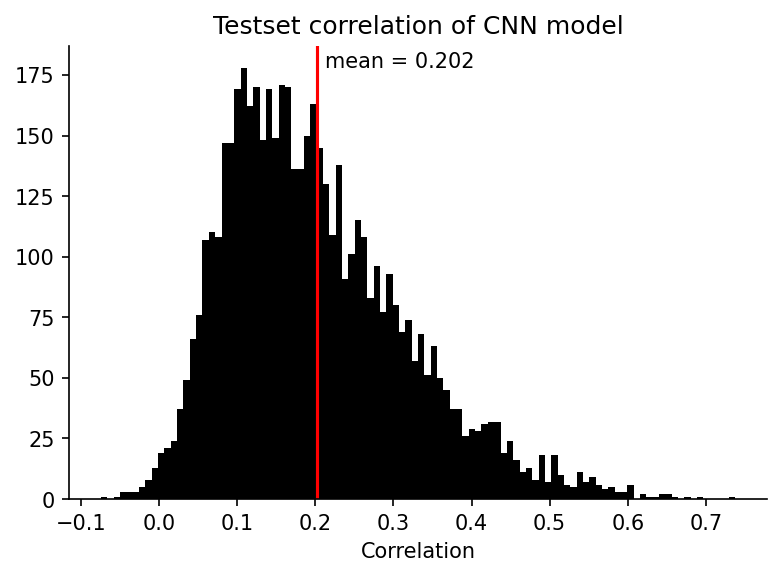

In [63]:
# compute correlation on test set
cnn_test_correlations = measures.get_correlations(
    cnn_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(cnn_test_correlations, bins=100, color='k')
mean_corr = np.mean(cnn_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of CNN model')
ax.set_xlabel('Correlation')
sns.despine()

So on average, it seems to do better than our simple LN model. Let's compare the performance for each neuron between the two models.

### TRY IT OUT
Compare the performance of the LN vs CNN models by plotting the correlation performance of both models for each neuron separately.

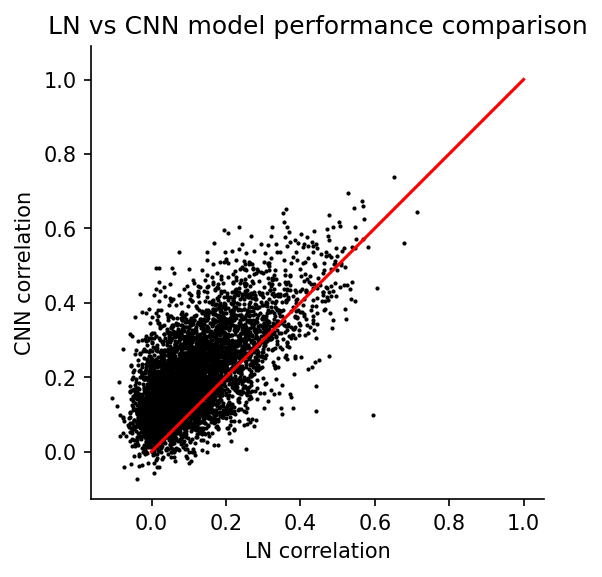

In [64]:
# compare model performance
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(ln_test_correlations, cnn_test_correlations, color="k", s=1)
ax.set_xlabel('LN correlation')
ax.set_ylabel('CNN correlation')
ax.set_title('LN vs CNN model performance comparison')
ax.plot([0, 1], [0, 1], color='r')
ax.axis('square')
sns.despine()

Here each dot corresponds to a single neuron, plotting the LN vs CNN model's performance in predicting that neuron's responses. Red diagonal establishes the equal performance line.

You can appreciate that for vast majority of neurons (each black point), the CNN model yields better predictive performance than the LN model.

## Trying out the State-of-the-Art (SOTA) model

Now that we got some sense on how we could go about training linear and nonlinear network models to predict V1 neuron responses to natural images, and we just saw how using a CNN model brings significant improvement to the performance beyond the LN model.

You might now be wondering, how good can we get? To get a sense of this, let's go ahead and train a state-of-the-art (SOTA) CNN model for mouse V1 responses to natual images as published in our recent work in [Lurz et al. ICLR 2021](https://github.com/sinzlab/Lurz_2020_code).

To keep things simple, I have provided for the network implementation in the `fens` package, so you can build the model just by invoking a function!

In [ ]:
from fens.models import build_lurz2020_model

# configuration for the model. Values are taken from the paper.
model_config = {'init_mu_range': 0.55,
                'init_sigma': 0.4,
                'input_kern': 15,
                'hidden_kern': 13,
                'gamma_input': 1.0,
                'grid_mean_predictor': {'type': 'cortex',
                                        'input_dimensions': 2,
                                        'hidden_layers': 0,
                                        'hidden_features': 0,
                                        'final_tanh': False},
                'gamma_readout': 2.439
               }

sota_cnn_model = build_lurz2020_model(**model_config, dataloaders=dataloaders, seed=1234)

In [ ]:
# Uncomment this line to train the network instead
#score, output, model_state = train_model(model=sota_cnn_model, dataloader=dataloaders, device='cuda')

state_dict = torch.load("./trained_nets/sota_cnn_model_state.pt")
sota_cnn_model.load_state_dict(state_dict)

As usual, let's take a look at the testset performance.

In [ ]:
# compute correlation on test set
sota_cnn_test_correlations = measures.get_correlations(
    sota_cnn_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(sota_cnn_test_correlations, bins=100, color='k')
mean_corr = np.mean(sota_cnn_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of SOTA CNN model')
ax.set_xlabel('Correlation')
sns.despine()

It turns out that we can have a *linearized* version of the SOTA model. This effectively removes all nonlinear operations within the network except for the very last nonlinear activation, rendering the network into a **LN model** but with more complex architecture.

In [ ]:
linear_model_config = dict(model_config) # copy the config
linear_model_config['linear'] = True # set linear to True to make it a LN model!

sota_ln_model = build_lurz2020_model(**linear_model_config, dataloaders=dataloaders, seed=1234)

In [ ]:
# Uncomment this line to train the network instead
#score, output, model_state = train_model(model=sota_ln_model, dataloader=dataloaders, device='cuda')

state_dict = torch.load("./trained_nets/sota_ln_model_state.pt")
sota_ln_model.load_state_dict(state_dict)

In [ ]:
# compute correlation on test set
sota_ln_test_correlations = measures.get_correlations(
    sota_ln_model, dataloaders["test"], device="cuda", per_neuron=True
)

fig, ax = plt.subplots(1, 1, dpi=150)
n, bins, _ = ax.hist(sota_ln_test_correlations, bins=100, color='k')
mean_corr = np.mean(sota_ln_test_correlations)
ax.axvline(mean_corr, color="r")
ax.text(
    x=mean_corr + 0.01,
    y=np.max(n),
    s="mean = {:.3f}".format(mean_corr),
)
ax.set_title('Testset correlation of SOTA LN model')
ax.set_xlabel('Correlation')
sns.despine()

Interestingly, you can see that compared to our simple LN model, the SOTA LN model actually attains much better performance. This, among other things, reflects the **ease of training** the CNN based network compared to our *fully-connected* simple linear model. Despite the architectural complexity of the SOTA LN model, it is still a LN model as was described mathematically as:

$$
\mathbf{r} = a(\mathbf{W} x + \mathbf{b})
$$

### Compare model performance between SOTA CNN and SOTA LN model

Just as before, let's compare the performanc of SOTA CNN vs SOTA LN.

In [ ]:
# compare model performance
fig, ax = plt.subplots(1, 1, dpi=150)
ax.scatter(sota_ln_test_correlations, sota_cnn_test_correlations, color="k", s=1)
ax.set_xlabel('SOTA LN correlation')
ax.set_ylabel('SOTA CNN correlation')
ax.set_title('SOTA LN vs CNN model performance comparison')
ax.plot([0, 1], [0, 1], color='r')
ax.axis('square')
sns.despine()

We can see that SOTA CNN model still performs better than the SOTA LN model across most of the neurons.

# Analyzing the trained models to gain insights into the brain

Now that we have trained some models successfully with decent predictive performances, you might be wondering what can we do with these models?

Ideally, we could use these models to gain insights into the modeled neurons, and even potentially derive new predictions that can then be tested with a new set of experiments.

Let's first analyze the **gradient receptive field (RF)** of the modeled neurons to get a rough sense of what is it that each neuron is *looking for* in the image when they respond.

## Gradient Receptive Fields (RF)

Let's consider our simple linear-nonlinear (LN) model. Recall from above that for each neuron, the response of the model to an image $x$ can be captured as follows:

$$
r = a(\mathbf{w}^\top x + b)
$$

and I already mentioned that the $\mathbf{w}$ can be thought of as a image filter that selects out pixels that the neuron cares about. This filter is typically referred to as the **receptive field** of the (LN) neuron.

It can actually be seen that we can **compute** the receptive field $\mathbf{w}$ by simply taking the **gradient of the response with respect to the input image**:

$$
\nabla_x r = a^\prime(\mathbf{w}^\top x + b) \cdot \mathbf{w}
$$

You could see that $a^\prime(\mathbf{w}^\top x + b)$ is still a scalar function that will evalute to some scalar value, and therefore,

$$
\nabla_x r \propto \mathbf{w}
$$

Therefore, you can compute the gradient of the model with respect to the input image to get the receptive field $\mathbf{w}$ up to some scalar constant. This method of obtaining the receptive field is commonly referred to as the **gradient receptive field (RF)**.

Note that for LN model, gradient RF correctly approximates the weight $\mathbf{w}$. However when this is applied to more highly nonlinear models like CNNs, the gradient RF can be thought of as giving a locally linear approximation to the CNN model, and still provide some rough insight into what is it that each neuron is looking for when they respond to an image.

Let's now go ahead and compute the gradient RF for our models. We will make use of the PyTorch automatic differentiation system to easily compute the gradient with respect to the image.

**DETAILS**: For LN model, it actually doesn't matter too much *where* you compute the gradient at (that is, what value of input image $x$ you will feed in). However the "where" can matter quite a bit more when evaluting gradient RF for highly nonlinear models such as our CNN model. For this reason, we are going to feed in an *average image* which will be a gray image with intensity set to the average value across all images in the training set. This value has been precomputed and provided as part of the `dataset` that underlies our data loaders.

Let us define a function that, when given a model, neuron index, and the image at which point you want to evaluate the gradient, returns the gradient RF.

In [ ]:
def generate_grad_rf(model, neuron_idx, input_image, device="cuda"):
    assert input_image.ndim == 2
    # prepare input image with requires_grad = True so that gradient will be computed
    x = torch.tensor(
        input_image.copy()[None, None, ...],
        dtype=torch.float,
        device=device,
        requires_grad=True,
    )
    # be sure to put the model on eval mode
    model.eval()
    model.to(device)
    # get the response of the target neuron
    model_activation = model(x)[:, neuron_idx]
    # compute gradient with respect to the input
    model_activation.backward()
    
    # prepare the gradient RF
    grad_rf = x.grad.data.cpu().numpy().squeeze()
    return grad_rf

In [ ]:
# choose input mean as starting point
input_mean = dataset.statistics.images.all.mean
input_std = dataset.statistics.images.all.std

Let's go ahead and genearte and visualize the grad RF for both our SOTA CNN and SOTA LN models.

In [ ]:
# select neuron to compute RFs
neuron_idx = 1

In [ ]:
# generate a gradient receptive field from the sota_model and the sota_ln_model
input_image = np.zeros((36, 64)) + input_mean

grad_rf_sota_cnn = generate_grad_rf(
    sota_cnn_model, neuron_idx=neuron_idx, input_image=input_image
)
grad_rf_sota_ln = generate_grad_rf(
    sota_ln_model, neuron_idx=neuron_idx, input_image=input_image
)

# visualize the two gradient RFs side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), dpi=150)

scale = np.max([np.max(np.abs(img)) for img in [grad_rf_sota_cnn, grad_rf_sota_ln]])

axes[0].imshow(grad_rf_sota_cnn, cmap="gray")
axes[0].set_title("SOTA CNN model")
axes[0].axis("off")

axes[1].imshow(grad_rf_sota_ln, cmap="gray")
axes[1].set_title("SOTA LN model")
axes[1].axis("off")

fig.suptitle("Gradient receptive fields", y=0.8)

It can be seen that, the gradient RF look grossly similar between the CNN model and LN model.

### TRY IT OUT
Explore the gradient RF for other neurons. Do you see the grad RF for CNN and LN differing significantly?

## Most Exciting Inputs

As we have mentioned above, the gradient RF is a local linear approximation of the CNN model and could vary a lot when computed with different input image. To gain a global insight of the modeled neuron's feature selectivity, we will derive their **Most Exciting Inputs (MEIs)**.
As the name implies, an MEI is the input $x$ that maximizes a specific modeled neuron's response. To generate the MEI for a targeted neuron $i$, we optimize the model-predicted activation $f_i$ with respect to the input image $x$, yielding:

$$
x_i = \text{argmax}_x f_i(x, \theta)
$$

We will be using the SGD optimizer in PyTorch to solve this optimization problem. Since the optimization algorithms implemented in PyTorch are all designed to minimize the loss function, we use negative model activation as the loss function.

We are working with modeled neurons that do not necessarily have a 'maximal firing rate' unlike the biological neurons, thus it is common to compute the MEIs with certain constraints to ensure $x$ maintains roughly in the input space that the model is trained on. A common approach is to fix the mean and standard deviation of $x$ during optimization at reasonable values. In the following experiment, we fix the mean at the mean of the training set and std at 1/10th of the std of the training set. Feel free to explore MEIs generated with different constraints!

The input image used as the starting point of the optimization in theory should not affect the MEI if the optimization finds the global maximum every time and there exists only one maximum. Here, we chose an input image randomly initiated with a normal distibution. You are encouraged to try out different input images and explore the differences in the resulting MEIs.

In [ ]:
from tqdm import tqdm

def generate_mei(
    model,
    input_image,
    neuron_idx,
    iterations,
    mean_constr,
    std_constr,
    lr=1,
    device="cuda",
    disable_progress_bar=False,
):
    assert input_image.ndim == 2
    std_constr = torch.tensor(std_constr).to(device)
    mean_constr = torch.tensor(mean_constr).to(device)

    # be sure to put the model on eval mode
    model.eval()
    model.to(device)
    
    # prepare input image with requires_grad = True so that gradient will be computed
    x = torch.tensor(
        input_image.copy()[None, None, ...],
        dtype=torch.float,
        device=device,
        requires_grad=True,
    )

    optimizer = torch.optim.SGD([x], lr=lr, momentum=0.9)
    model_activations = []
    for i in tqdm(range(iterations), disable=disable_progress_bar):
        # fix the mean and std of the input image
        transformed_x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr  # 1e-4 is added to avoid division by zero
        model_activation = model(transformed_x)[:, neuron_idx]
        (-model_activation).backward()
        model_activations.append(model_activation.detach().cpu().numpy())
        optimizer.step()
    # finally, reapply the mean and norm constrain on the image
    x = (x - x.mean()) / (x.std() + 1e-4) * std_constr + mean_constr
    return np.array(model_activations), x.detach().cpu().numpy().squeeze()



Now let's go ahead and genearte the MEIs for both SOTA CNN and SOTA LN models for the same target neuron.

In [ ]:
# generate a gradient receptive field from the sota_model and the sota_ln_model
activation_sota_cnn, mei_sota_cnn = generate_mei(
    sota_cnn_model,
    input_image=np.random.normal(input_mean, 0.1, (36, 64)),
    neuron_idx=neuron_idx,
    iterations=2000,
    mean_constr=input_mean,
    std_constr=input_std / 10,
    lr=100,
)

activation_sota_ln, mei_sota_ln = generate_mei(
    sota_ln_model,
    input_image=np.random.normal(input_mean, 0.1, (36, 64)),
    neuron_idx=neuron_idx,
    iterations=2000,
    mean_constr=input_mean,
    std_constr=input_std / 10,
    lr=100,
)


...and finally, let's take a look at the MEIs!

In [ ]:
# compare the two meis
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), dpi=150)
axes[0,0].imshow(mei_sota_cnn, cmap='gray')
axes[0,0].axis('off')
axes[0,0].set_title('SOTA CNN model')
axes[1,0].plot(activation_sota_cnn)
axes[1,0].set_ylabel('Model activation')
axes[1,0].set_xlabel('Iterations')
axes[0,1].imshow(mei_sota_ln, cmap='gray')
axes[0,1].axis('off')
axes[0,1].set_title('SOTA LN model')
axes[1,1].plot(activation_sota_ln)
axes[1,1].set_xlabel('Iterations')
plt.suptitle('MEIs', y=1.02)

### MEI cross activation

Finally, we check how a neuron's MEI cross-activates other neurons. This will allow us to get a sense of how unique is each MEI, and potentially find a group of neurons that share similar MEIs. As it takes a long time to generate MEI, he we restrict ourselves to generate 5 MEIs and then compute cross activation.

In [ ]:
# pick random 5 neurons
neuron_idx_ls = [1, 48, 1092, 2008, 4029] # randomly selected 5 neurons
meis = []
for i in tqdm(neuron_idx_ls):
    _, mei = generate_mei(
            sota_cnn_model,
            input_image=np.random.normal(input_mean, input_std / 10, (36, 64)),
            neuron_idx=i,
            iterations=500,
            mean_constr=input_mean,
            std_constr=input_std / 10,
            disable_progress_bar=True,
    )
    meis.append(mei)

meis = torch.tensor(np.stack(meis))[:, None, ...]

In [ ]:
# run MEIs through the network
activations = sota_cnn_model(meis.cuda()).cpu().detach().numpy().squeeze()[:, neuron_idx_ls]

# normalize activation by the heighest activation for each neuron
activations = activations / activations.max(axis=0, keepdims=True)

fig, ax = plt.subplots(1, 1, dpi=150)
ax.imshow(activations, cmap='gray')
ax.set_ylabel('MEIs')
ax.set_xlabel('Neurons')

### TRY IT OUT
Explore MEIs of other neurons and their cross activations. Do you see any patterns?

# Group Projects

Congratulations! You have successfully trained DNN models of the V1 responses to natural images and even looked at how we can dig into the trained network to gain potential insights into the modeled systems by computing gradient RFs and MEIs.

Now it's time for you to get wild and explore your own questions! Working in a group of 4-5 students, pick a project that involves a DNN model of the population responses. Below are some possible project directions you could base yours off of--or you could decide to take a completely novel direction!

* In-silico experiments
    * Having a well-trained DNN model opens up a lot of possibilities for performing so-called *in silico* experiments, where you could present any kind of stimulus to your model and characterize neurons' responses. Pick and find a paper with experiments that investigate/characterize V1 responses to stimulus, and replicate the study on your DNN model. Does your result agree with the finding from the paper on V1? If not, why do you think it fails to agree?
* Improve the DNN model
    * Starting with CNN model we built, consider how you would go about improving this network. Feel free to consult existing state-of-the-art networks. What do you think would be critical in improving your network performance?
    * Throughout the whole training, we used Poisson loss. We already discussed how this is the same as assuming that neurons fire according to independent Poisson distribution. Is this a good assumption after all? If not, how could you go about improving on this? (Hint: consider different training loss/criterion. `train_model` can take in optional `loss` argument)
* Exploring MEIs
    * MEIs are very rich stimuli that seem to differ from the classic notion of V1 as a bank of Gabor filters. Can you group neurons based on "similar" MEIs?
    * Some MEIs look more like RFs than others. Is there some underlying pattern to this?
    * MEIs are images that are built to "maximize" the activation of the neurons. Can you come up with image(s) that optimize some other objective? What would it tell you about the neurons/population?